## Notebook for Project - Traffic Lane Findings

### This is the notebook for project - detect tranffic lanes by Wenbo Ma

### This notebook is to demonstrate each steps in the whole pipeline to process each frame in a video

In [2]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from numpy.linalg import inv
import glob
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]

### Helper Function

In [3]:
def input_image(img_file):
    """ load an image file into python
        return an image array
    """
    return mpimg.imread(img_file)


def read_image(img_folder):
    """
        load all images from a folder
    """
    for filename in os.listdir(img_folder):
        fig = plt.figure()
        image = input_image(img_folder+filename)
        plt.subplot(121)
        plt.imshow(image)

### Camera Calibration

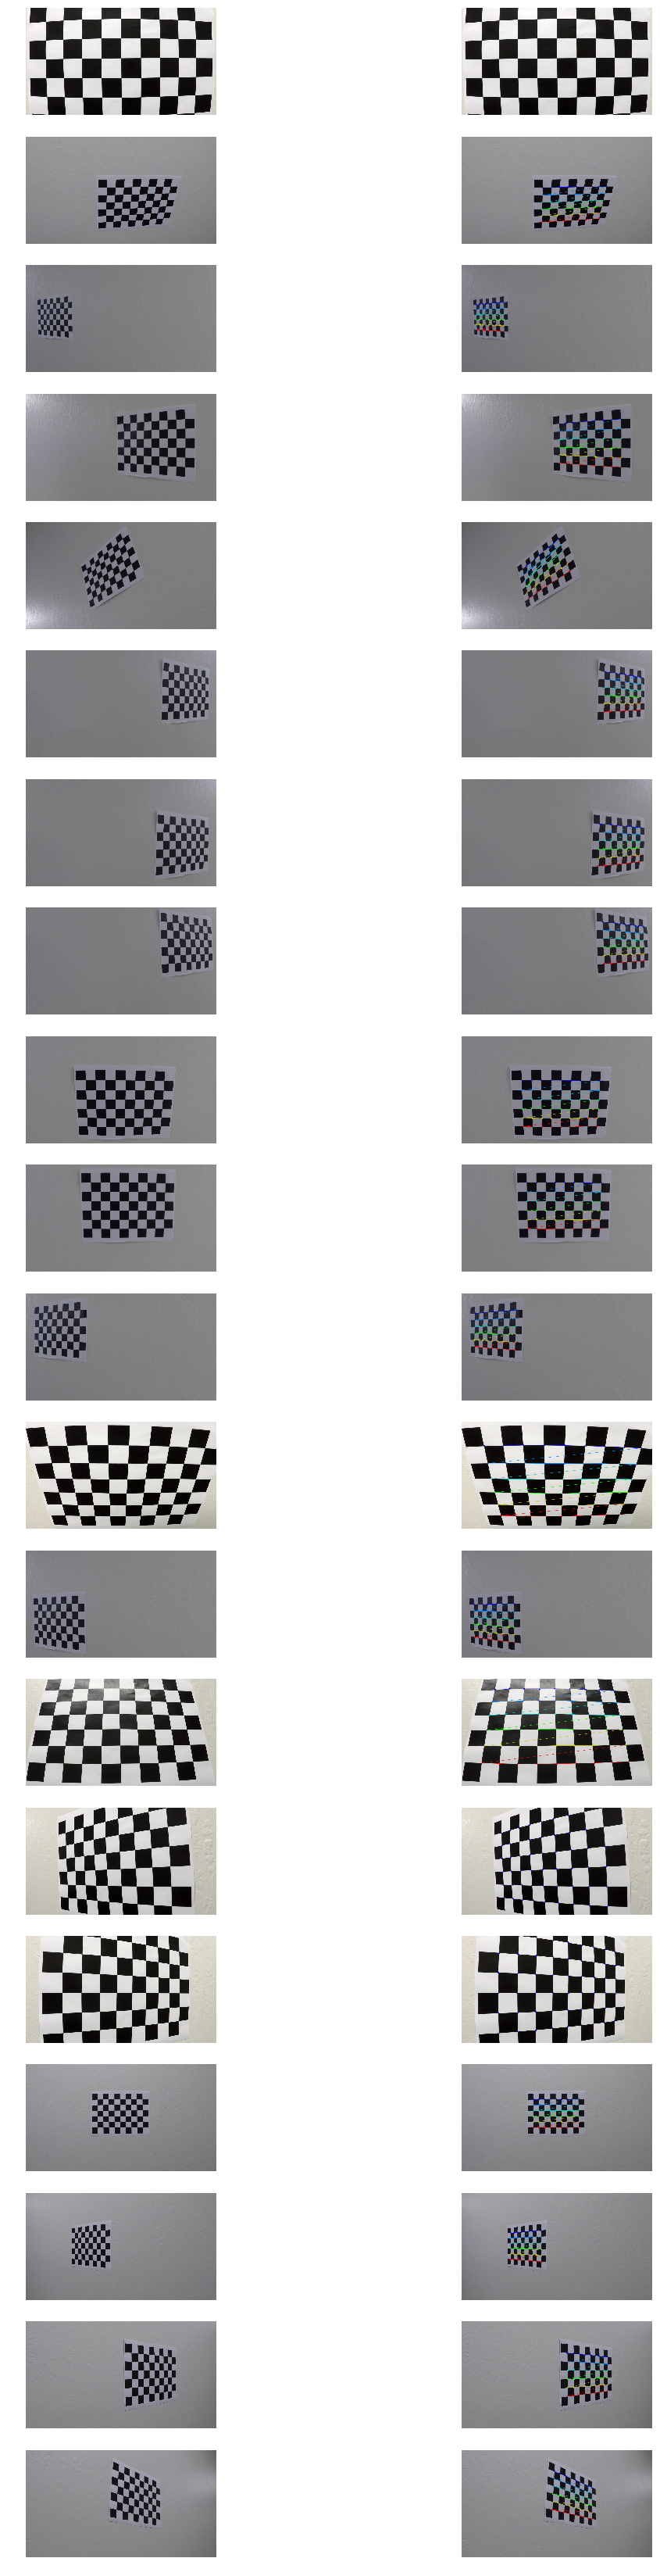

In [4]:
-

calimg_directory = "E:/Project/Udacity - Computer Vision/P4 Advanced Lane Finding/CarND-Advanced-Lane-Lines-master/CarND-Advanced-Lane-Lines-master/camera_cal/"
objpoints,imgpoints = camera_calibration(calimg_directory)

### Undistort an Image

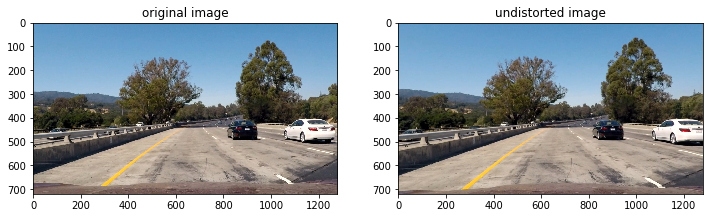

In [5]:
def cal_undistort(img,objpoints,imgpoints):
    """
        undistorted an image
    """
    ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,(1280,720),None,None)
    dst = cv2.undistort(img,mtx,dist,None,mtx)
    return dst

testimg_directory = "E:/Project/Udacity - Computer Vision/P4 Advanced Lane Finding/CarND-Advanced-Lane-Lines-master/CarND-Advanced-Lane-Lines-master/test_images/"
testimg = plt.imread(testimg_directory + "test1.jpg")

# testimg_directory = 'E:/Project/Udacity - Computer Vision/P4 Advanced Lane Finding/Difficult Frame/'
# testimg = plt.imread(testimg_directory+"difficult2.png")

fig,(ax1,ax2) = plt.subplots(1,2)
ax1.set_title('original image')
ax1.imshow(testimg)
undistort_testimg = cal_undistort(testimg,objpoints,imgpoints)
ax2.set_title('undistorted image')
ax2.imshow(undistort_testimg)

### HLS Thresholding

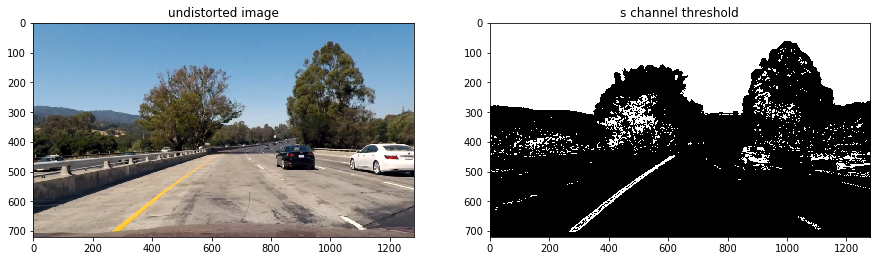

In [6]:
def hls_threshold(img,channel="s",thresh=(0,255)):
    img_hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    if channel == "h":
        img_hls = img_hls[:,:,0]
    elif channel == "l":
        img_hls = img_hls[:,:,1]
    else:
        img_hls = img_hls[:,:,2]
    bin_hls = np.zeros_like(img_hls)
    bin_hls[(img_hls>thresh[0]) & (img_hls<thresh[1])] = 1 # set pixiel within threshold as white
    return bin_hls



s_thresh = hls_threshold(undistort_testimg,thresh=(100,255))
f,(ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
ax1.set_title("undistorted image")
ax1.imshow(undistort_testimg,cmap="gray")
ax2.set_title("s channel threshold")
ax2.imshow(s_thresh,cmap="gray")

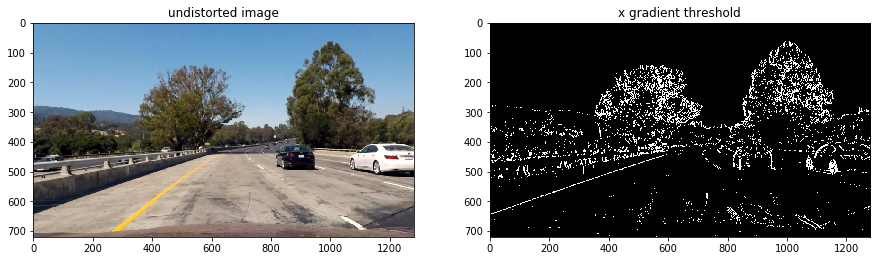

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3,thresh=(0,255)):
    """
        apply sobel operator on either 'x' or 'y' direction
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Convert to grayscale
    
    """ Apply x or y gradient with the OpenCV Sobel() function and take the absolute value """
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel)) # Rescale back to 8 bit integer
    binary_output = np.zeros_like(scaled_sobel) # Create a copy and apply the threshold
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1 #thresholds, but exclusive is ok too
    return binary_output

x_thresh = abs_sobel_thresh(undistort_testimg,sobel_kernel=3,thresh=(20,255))
f,(ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
ax1.set_title("undistorted image")
ax1.imshow(undistort_testimg,cmap="gray")
ax2.set_title("x gradient threshold")
ax2.imshow(x_thresh,cmap="gray")

### Thresholding (HLS + X Gradient) on all test images

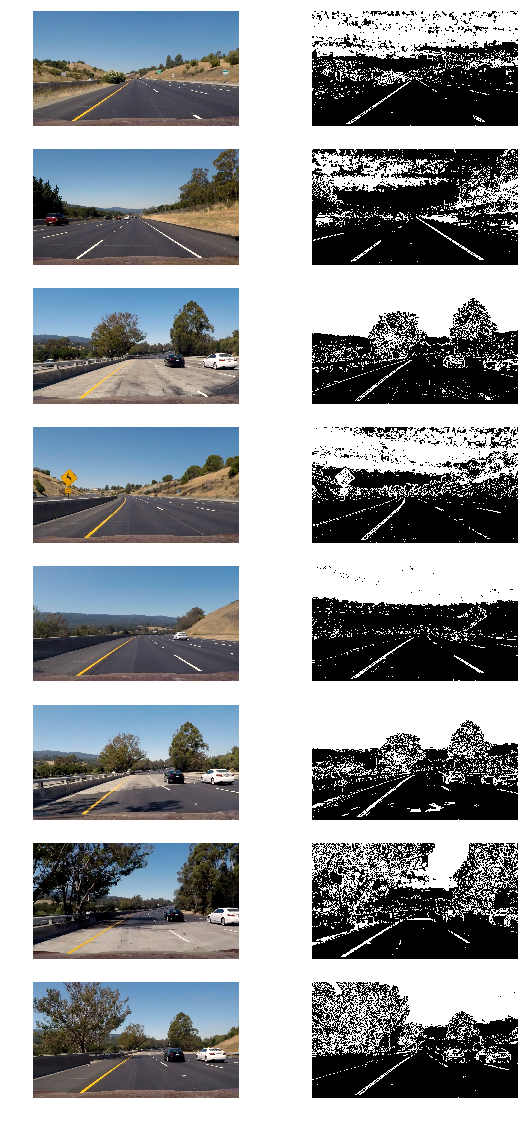

In [8]:

# Make a list of example images
images = glob.glob('E:/Project/Udacity - Computer Vision/P4 Advanced Lane Finding/CarND-Advanced-Lane-Lines-master/CarND-Advanced-Lane-Lines-master/test_images/*.jpg')
# images = glob.glob('E:/Project/Udacity - Computer Vision/P4 Advanced Lane Finding/Difficult Frame/*.png')

# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

i = 0
for image_path in images:
    img_origin = plt.imread(image_path)
    img = cal_undistort(img_origin,objpoints,imgpoints)
    img_hls = hls_threshold(img,thresh=(100,255))
    img_x = abs_sobel_thresh(img,sobel_kernel=5,thresh=(20,255))
    img_comb = np.zeros_like(img_x)
    img_comb[(img_hls==1) | (img_x==1)] = 1
    axs[i].imshow(img_origin)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_comb, cmap='gray')
    axs[i].axis('off')
    i += 1

### Perspective Transformation

Text(0.5,1,'birds-eye view of testing image')

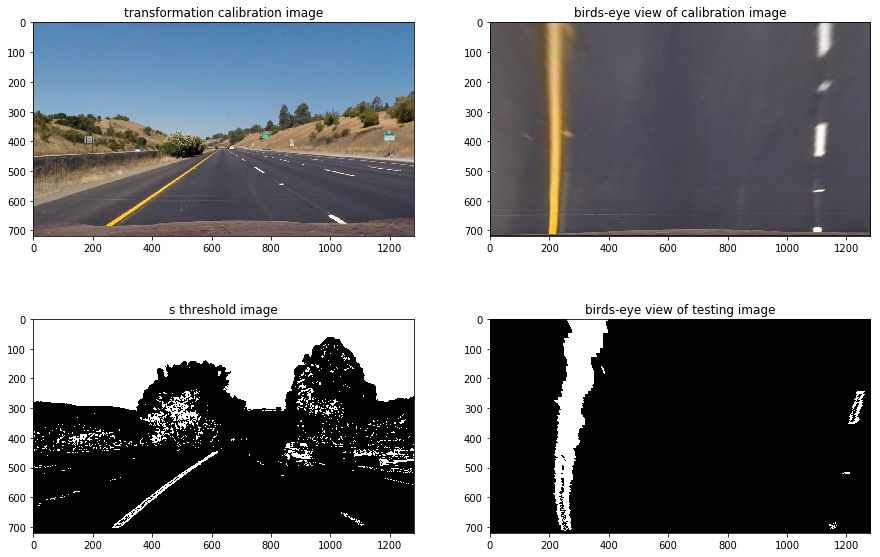

In [9]:
def get_transform_matrix(calibration_img, objpoints,imgpoints):
    
    """
        The output of this step is the transformation matrix M
    """
    calibration_img = cal_undistort(calibration_img, objpoints, imgpoints)
    
    h,w = calibration_img.shape[:2]
    
    src = np.float32([(578,461),
                      (200,717), 
                      (1109,717), 
                      (700,461)])
    dst = np.float32([(200,0),
                      (200,717),
                      (1109,717),
                      (1109,0)])
    
    M = cv2.getPerspectiveTransform(src, dst) # get transformation matrix
    InvM = cv2.getPerspectiveTransform(dst,src) # get inverse of transformation matrix
    img_size = (calibration_img.shape[1],calibration_img.shape[0]) # image size (width,height)
    warped = cv2.warpPerspective(calibration_img, M, img_size,flags=cv2.INTER_LINEAR)
    return warped,M,InvM

def perspective_transform(img):

    """
    In this step, the input is a thresholded images. The goal of
    this step is to transform the input into "bird-eye" perspective
    
    the sub-steps in persepective transform is to 
            1) find source and destination points
               in an image, 
            2) put them into cv2.getPerspectiveTransform() function to obtain transformation
               matrix M and 
            3) finally use M to transform any testing images
    
    Step (1) and (2) have been finished at the preprocessing stage at the very beginning
    of the pipeline as these steps just have to be done once.
    """
    img_size = (img.shape[1],img.shape[0]) # image size (width,height)
    warped = cv2.warpPerspective(img, M, img_size)
    return warped

calibrate_img = plt.imread('E:/Project/Udacity - Computer Vision/P4 Advanced Lane Finding/CarND-Advanced-Lane-Lines-master/CarND-Advanced-Lane-Lines-master/test_images/' + "straight_lines1.jpg")
calibrate_warped,M,InvM = get_transform_matrix(calibrate_img,objpoints,imgpoints)

f,ax = plt.subplots(2,2,figsize=(15,10))

warped = perspective_transform(s_thresh)

# visualization
ax[0,0].imshow(calibrate_img)
ax[0,0].set_title("transformation calibration image")
ax[0,1].imshow(calibrate_warped)
ax[0,1].set_title("birds-eye view of calibration image")
ax[1,0].imshow(s_thresh,cmap='gray')
ax[1,0].set_title("s threshold image")
ax[1,1].imshow(warped,cmap="gray")
ax[1,1].set_title("birds-eye view of testing image")

### Test undistortion, thresholding and perspective transformation on an image

(0.0, 1.0, 0.0, 1.0)

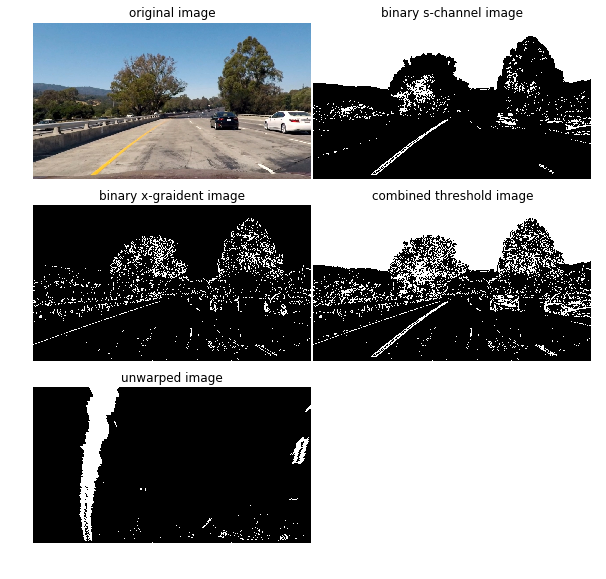

In [16]:
fig, axs = plt.subplots(3,2, figsize=(10, 10))
fig.subplots_adjust(hspace = .02, wspace=.01)
axs = axs.ravel()


img = np.copy(undistort_testimg)
axs[0].imshow(img)
axs[0].set_title('original image')
axs[0].axis('off')

img_hls = hls_threshold(img,thresh=(100,255))
axs[1].imshow(img_hls,cmap='gray')
axs[1].set_title('binary s-channel image')
axs[1].axis('off')


img_x = abs_sobel_thresh(img,sobel_kernel=3,thresh=(20,255))
axs[2].imshow(img_x,cmap='gray')
axs[2].set_title('binary x-graident image')
axs[2].axis('off')


img_comb = np.zeros_like(img_x)
img_comb[(img_hls==1) | (img_x==1)] = 1
axs[3].imshow(img_comb,cmap='gray')
axs[3].set_title('combined threshold image')
axs[3].axis('off')


warped = perspective_transform(img_comb)
axs[4].imshow(warped,cmap='gray')
axs[4].set_title('unwarped image')
axs[4].axis('off')

axs[5].axis('off')


### Pipeline to Process All Test Images

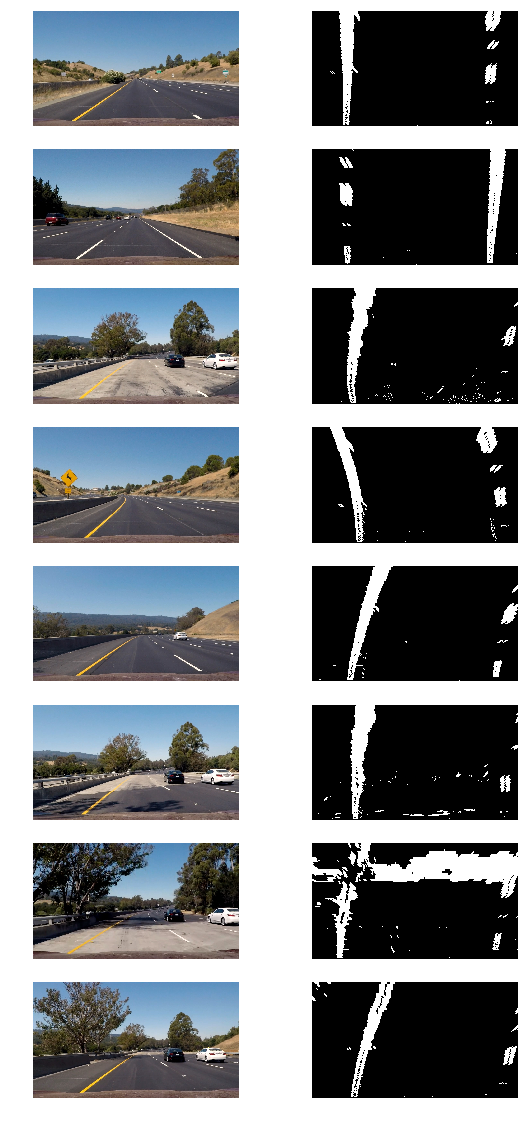

In [15]:
def pipeline(img):
    # undistort image
    img_cp = np.copy(img)
    img_cp = cal_undistort(img_cp,objpoints,imgpoints)
    # thresholding
    img_hls = hls_threshold(img_cp,thresh=(100,255))
    img_x = abs_sobel_thresh(img_cp,sobel_kernel=5,thresh=(20,255))
    img_comb = np.zeros_like(img_x)
    img_comb[(img_hls==1) | (img_x==1)] = 1
    # perspective transformation
    img_comb = perspective_transform(img_comb)
    return img_comb
    
# run pipeline to all test images

# Make a list of example images
images = glob.glob('E:/Project/Udacity - Computer Vision/P4 Advanced Lane Finding/CarND-Advanced-Lane-Lines-master/CarND-Advanced-Lane-Lines-master/test_images/*.jpg')

# images = glob.glob('E:/Project/Udacity - Computer Vision/P4 Advanced Lane Finding/Difficult Frame/*.png')

# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

i = 0
for image_path in images:
    img = plt.imread(image_path)
    img_bin = pipeline(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1

### Detect Lane - Sliding Window Polyfit

In [26]:
def slide_window_polyfit(binary_warped):
    """
        function to detect pixels belonging to lanes
        
        Input is a binary unwarped image
    """

    """ get histogram to locate starting point in x direction """
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0) # column sum for lower part of the image
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255 # Create an output image to draw on and  visualize the result
    
    """get starting point for the left and right lane """
    midpoint = np.int(histogram.shape[0]//2) # midpoint location in the x-axis
    leftx_base = np.argmax(histogram[:midpoint]) # location with peak in histogram for left lane
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint # location with peak in histogram for right lane
    
    """ sliding window to detect all pixels that are part of lanes """
    nwindows = 10 # Choose the number of sliding windows
    window_height = np.int(binary_warped.shape[0]//nwindows) # Set height of windows
    nonzero = binary_warped.nonzero() # indices of pixels with nonzero values
    nonzeroy = np.array(nonzero[0]) # indices in y coordinate
    nonzerox = np.array(nonzero[1]) # indices in x coordinate

    leftx_current = leftx_base # Current positions to be updated for each window
    rightx_current = rightx_base
    margin = 100 # Set the width of the windows +/- margin
    minpix = 50 # Set minimum number of pixels found to recenter window
    left_lane_inds = [] # Create empty lists to receive left and right lane pixel indices
    right_lane_inds = []

    """ Step through the windows one by one """
    for window in range(nwindows):
        """
            Identify window boundaries in x and y (and right and left)
            low and high is in indice sense.
        """
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        """ Draw the windows on the visualization image """
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0] # good_left_inds contains all position index where pixel value is 1
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds])) # reset starting x for next window
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    """ Concatenate the arrays of indices """
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    """ Extract left and right line pixel positions """
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    """ Fit a second order polynomial to each lane """
    left_fit = np.polyfit(lefty, leftx, 2) # y is the independent variable and x is dependent variable
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return leftx,lefty,rightx,righty,left_fitx,right_fitx,left_fit,right_fit

### Polyfit using previous fit

In [27]:
def polyfit_with_previous(binary_warped):
    """
        function to fit polynomial regression on new image with previous fitted information/coefficients
        
        The key assumption here is the lanes' position doesn't change a lot from frame to frame
    """
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    
    # Since we have already detect the lane in the first frame, for the subsequent frame,
    # we don't have to re-search using the sliding window again. Instead, we just use the
    # nonzero point's y coordinate and their fitted value +/- margin  (fitted x coordinate)
    # to collect pixels that are part of lanes
    left_fit = np.copy(left_lane.best_fit)
    right_fit = np.copy(right_lane.best_fit)
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except TypeError:
        plt.figure()
        plt.imshow(binary_warped)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return leftx,lefty,rightx,righty,left_fitx,right_fitx,left_fit,right_fit



### Compute Radius of Curvature

In [40]:
def cal_radius(img):
    """
        compute radius of curvature
        
        img: binary warped image    
    """
    
    # convert from pixel space to physical space
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # generate y value
    h = img.shape[0] # image height
    ploty = np.linspace(0,h-1,h)
    y_eval = np.max(ploty) # the pixel cloest to the vehicle (the bottom pixel)
    
    left_fitx = left_lane.draw_fit[0]*ploty**2 + left_lane.draw_fit[1]*ploty+left_lane.draw_fit[2]
    right_fitx = right_lane.draw_fit[0]*ploty**2 + right_lane.draw_fit[1]*ploty + right_lane.draw_fit[2]
    lefty = np.copy(ploty)
    righty = np.copy(ploty)
    
    # Fit new polynomials to x,y in physical space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, left_fitx*xm_per_pix, 2) 
    right_fit_cr = np.polyfit(righty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the radius of curvature (the formula is from https://www.intmath.com/applications-differentiation/8-radius-curvature.php)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    curverad = np.mean([left_curverad,right_curverad])
    return curverad

### Draw Line

In [41]:
def draw_lane(image,img):
    """
        Drawing detected lane area onto original picture
        
        input:
            image: original image
            
            img: binary warped image
            
    """
    h = img.shape[0] # image height
    ploty = np.linspace(0,h-1,h)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero)) # create three channels
    
    # 
    left_fitx = left_lane.draw_fit[0]*ploty**2 + left_lane.draw_fit[1]*ploty+left_lane.draw_fit[2]
    right_fitx = right_lane.draw_fit[0]*ploty**2 + right_lane.draw_fit[1]*ploty + right_lane.draw_fit[2]
     
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))]) # flipud put each column upside down
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=25)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=25)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, InvM, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    #plt.figure()
    #plt.imshow(result)
    return result

### Draw Radius Data

In [63]:
def draw_data(original_img, curv_rad):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (50,600), font, 1.25, (200,0,155), 2, cv2.LINE_AA)
#     direction = ''
#     if center_dist > 0:
#         direction = 'right'
#     elif center_dist < 0:
#         direction = 'left'
#     abs_center_dist = abs(center_dist)
#     text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
#     cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

### Define a Class to Track Lanes

In [43]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # draw fit
        self.draw_fit = None
        
    def update(self,fit):
        """
            update 
        """
        # check if there is previous fit
        if len(self.current_fit) == 0:
            self.current_fit.append(fit)
            self.best_fit = np.mean(self.current_fit,axis=0)
            self.draw_fit = np.copy(self.best_fit)
        else:
            if abs(self.best_fit[0]-fit[0]) > 0.01 or \
                abs(self.best_fit[1]-fit[1]) > 1 or \
                    abs(self.best_fit[2]-fit[2]) > 100:
                # the fit is bad (too different from previous)
                if len(self.current_fit) == 1:
                    self.draw_fit = np.copy(self.best_fit) # use the current best_fit to draw
                    self.current_fit = [] # remove the last previous fit
                    self.best_fit = None
                else:
                    self.current_fit = self.current_fit[1:] # remove the oldest fit
                    self.best_fit =np.mean(self.current_fit,axis=0)
                    self.draw_fit = np.copy(self.best_fit)
            else:
                self.current_fit.append(fit)
                self.current_fit = self.current_fit[-5:] # keep at most 5 recent fit
                self.best_fit = np.mean(self.current_fit,axis=0)
                self.draw_fit = np.copy(self.best_fit)
                
                
        
            
            
#     def dequeue(self):
#         """
#             remove the oldest fit from current fit queue
#         """
#         if len(self.current_fit) > 1:
#             self.current_fit = self.current_fit[1:] # remove the oldest fit
#             self.best_fit = np.mean(self.current_fit,axis=0)
#         else:
#             self.current_fit = []

### Define Image Processing Pipeline

In [50]:
def process_image(img):
    """
        @parameters:
        ----------------
        img: distorted image (single frame) from a video
    """
    # undistort image
    img_cp = np.copy(img)
    img_cp = cal_undistort(img_cp,objpoints,imgpoints)
    # thresholding
    img_hls = hls_threshold(img_cp,thresh=(100,255))
    img_x = abs_sobel_thresh(img_cp,sobel_kernel=5,thresh=(20,255))
    img_cp = np.zeros_like(img_x)
    img_cp[(img_hls==1) | (img_x==1)] = 1
    
    # perspective transformation
    img_cp = perspective_transform(img_cp)
    
    # detect the lane from the current frame
    if (left_lane.best_fit is None) or (right_lane.best_fit is None):
        leftx,lefty,rightx,righty,left_fitx,right_fitx,left_fit,right_fit = slide_window_polyfit(img_cp)
        
    else:
        leftx,lefty,rightx,righty,left_fitx,right_fitx,left_fit,right_fit = polyfit_with_previous(img_cp) # use line object information

# ============================== debug ===============================
#     first sanity check:
#     check if the detected lane has width around 1100(+/-200)
#     h = img_cp.shape[0]
#     leftbase = left_fitx[h-1] # base point for left lane
#     rightbase = right_fitx[h-1] # base point for right lane
    
#     if (rightbase-leftbase) <= 1200 and \
#        (rightbase-leftbase) >= 900:
# ============================== end of debug ========================
    
    left_lane.update(left_fit)
    right_lane.update(right_fit)
    # calculate radius
    curverad = cal_radius(img_cp)
    # draw detected lane back to original picture
    result_img = draw_lane(img,img_cp)
    result_img = draw_data(result_img,curverad)
    return result_img
    

### Test the Pipiline on an Image

Text(0.5,1,'result image')

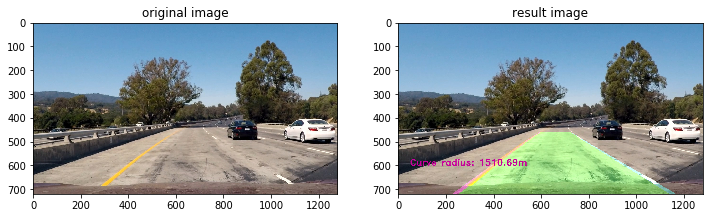

In [64]:
left_lane = Line()
right_lane = Line()

fig,(ax1,ax2) = plt.subplots(1,2)

ax1.imshow(testimg)
ax1.set_title('original image')
result=process_image(testimg)
ax2.imshow(result)
ax2.set_title('result image')

### Processing Video

In [52]:
from moviepy.editor import *
from IPython.display import HTML

In [65]:
def create_video(raw_video_path,output_path):
    raw_video = VideoFileClip(raw_video_path,audio=False)
    processed_clip = raw_video.fl_image(process_image)
    txt = TextClip("Produced by Wenbo Ma for Lane Detection Project", font='Amiri-regular',
	               color='white',fontsize=20)
    txt_col= txt.on_color(size=(processed_clip.w + txt.w,txt.h-5),
                  color=(0,0,0), pos=(6,'center'), col_opacity=0.6)
    w,h = processed_clip.size
    txt_mov = txt_col.set_pos(lambda t: (max(w/30,int(w-0.5*w*t)),40))
    composite_clip = CompositeVideoClip([processed_clip, txt_mov])
    composite_clip.subclip(0,processed_clip.duration).write_videofile(output_path,audio=False)
    raw_video.reader.close() # 
    %time composite_clip.write_videofile(output_path, audio=False)
    del raw_video.reader #

In [66]:
left_lane = Line()
right_lane = Line()

In [67]:
input_video = 'E:/Project/Udacity - Computer Vision/P4 Advanced Lane Finding/CarND-Advanced-Lane-Lines-master/CarND-Advanced-Lane-Lines-master/project_video.mp4'
output_video = "E:/Project/Udacity - Computer Vision/P4 Advanced Lane Finding/output/project_output_video.mp4"
create_video(input_video,output_video)

[MoviePy] >>>> Building video E:/Project/Udacity - Computer Vision/P4 Advanced Lane Finding/output/project_output_video.mp4
[MoviePy] Writing video E:/Project/Udacity - Computer Vision/P4 Advanced Lane Finding/output/project_output_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [26:32<00:01,  1.26s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: E:/Project/Udacity - Computer Vision/P4 Advanced Lane Finding/output/project_output_video.mp4 



ValueError: Attribute 'duration' not set